In [1]:
import numpy as np
import mne
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'

In [2]:
my_channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 
               'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 
               'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 
               'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 
               'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 
               'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 
               'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 
               'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
montage = mne.channels.make_standard_montage('biosemi64')
info = mne.create_info(ch_names=my_channels, sfreq=64, ch_types='eeg')
info.set_montage(montage)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,64.00 Hz
Highpass,0.00 Hz
Lowpass,32.00 Hz


In [3]:
from task2_regression.models.adt_env import ADT
model = ADT(chans=64, outputDims=1, F=8, T=16, D=4, heads=4, ff_dim=128, blocks=4, mask=True, use_bias=False, lrate=0.5)
model.build(input_shape=(None, 320, 64))
model.load_weights('./task2_regression/experiments/results_adt_env_best/model.h5')

In [4]:
model.summary()

Model: "adt"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction (feature  multiple                 2256      
 Extraction)                                                     
                                                                 
 expand_dims_layer (ExpandDi  multiple                 0         
 msLayer)                                                        
                                                                 
 squeeze_layer (SqueezeLayer  multiple                 0         
 )                                                               
                                                                 
 transformer_block (transfor  multiple                 41088     
 merBlock)                                                       
                                                                 
 transformer_block_1 (transf  multiple                 41088   

In [5]:
for weight in model.trainable_weights:
    print(weight.name, weight.shape)

feature_extraction/conv2d/kernel:0 (16, 1, 1, 8)
feature_extraction/layer_normalization/gamma:0 (8,)
feature_extraction/layer_normalization/beta:0 (8,)
feature_extraction/depthwise_conv2d/depthwise_kernel:0 (1, 64, 8, 4)
feature_extraction/layer_normalization_1/gamma:0 (32,)
feature_extraction/layer_normalization_1/beta:0 (32,)
transformer_block/multi_head_attention/query/kernel:0 (32, 4, 32)
transformer_block/multi_head_attention/key/kernel:0 (32, 4, 32)
transformer_block/multi_head_attention/value/kernel:0 (32, 4, 32)
transformer_block/multi_head_attention/attention_output/kernel:0 (4, 32, 32)
transformer_block/conv1d/kernel:0 (3, 32, 128)
transformer_block/conv1d_1/kernel:0 (3, 128, 32)
transformer_block/layer_normalization_2/gamma:0 (32,)
transformer_block/layer_normalization_2/beta:0 (32,)
transformer_block/layer_normalization_3/gamma:0 (32,)
transformer_block/layer_normalization_3/beta:0 (32,)
transformer_block_1/multi_head_attention_1/query/kernel:0 (32, 4, 32)
transformer_block

In [6]:
def filter(data, threshold=0.5):
    data = data / np.max(np.abs(data))
    for i in range(len(data)):
        if np.abs(data[i]) < threshold:
            data[i] = 0
    return data

In [7]:
weights = model.get_weights()

In [8]:
temp_weights = weights[0]
temp_weights = np.squeeze(temp_weights)
temp_weights.shape

(16, 8)

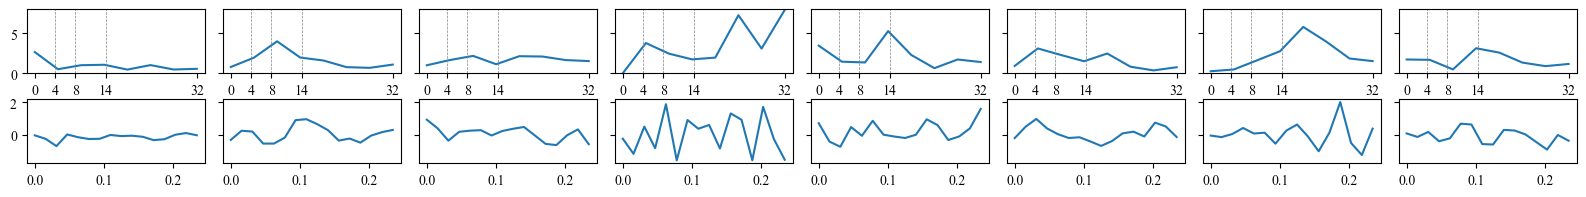

In [9]:
from scipy.fft import fft
t = np.arange(0, 0.25, 1/64)


fig, ax = plt.subplots(2, 8, figsize=(20,2), sharey='row')
fig.subplots_adjust(wspace=0.1, hspace=0.4)

for j in range(8):
    signal_fft = fft(temp_weights[:,j])
    signal_fft = signal_fft[:len(signal_fft)//2]
    freq = np.linspace(0, 64/2, len(signal_fft))
    ax[0][j].plot(freq, np.abs(signal_fft))
    ax[0][j].axvline(x=4, linestyle='--', color='grey', linewidth=0.5)
    ax[0][j].axvline(x=8, linestyle='--', color='grey', linewidth=0.5)
    ax[0][j].axvline(x=14, linestyle='--', color='grey', linewidth=0.5)
    ax[0][j].set_xticks([0, 4, 8, 14, 32])
    ax[0][j].set_ylim([0.0, 8.0])


    ax[1][j].plot(t, temp_weights[:,j])

#plt.savefig('weights_fig/adt_temporal_weights_tf.svg', format='svg', dpi=1200, bbox_inches='tight')

In [10]:
weights_spat = weights[3]
weights_spat = np.squeeze(weights_spat)
weights_spat.shape

(64, 8, 4)

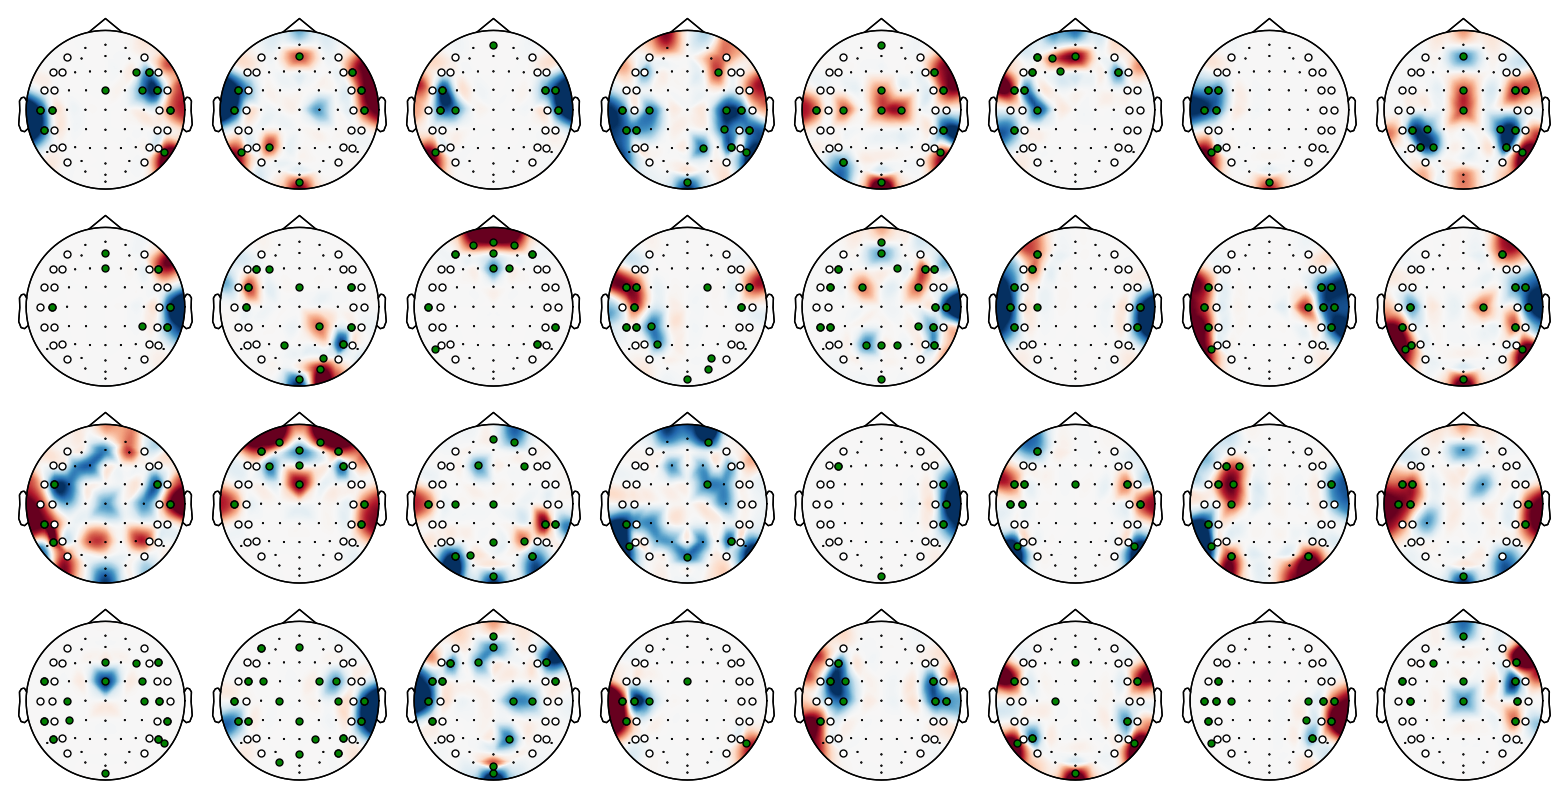

In [11]:
temporal_ch_names = [
    # temporal lobe
    'F7', 'F8',  # 前颞
    'T7', 'T8',  # 中颞
    'P7', 'P8',  # 后颞
    'FT7', 'FT8',  # 前颞-颞
    'TP7', 'TP8',  # 颞-顶
    
    # near temporal lobe
    'F5', 'F6',  # 额叶,邻近前颞区
    'C5', 'C6',  # 中央区,邻近中颞区
    'P5', 'P6',  # 顶叶,邻近后颞区
    'AF7', 'AF8',  # 前额极,邻近前颞区
    'FC5', 'FC6',  # 额-中央区,邻近前颞区
    'CP5', 'CP6',  # 中央-顶叶区,邻近后颞区
    'PO7', 'PO8'  # 顶-枕叶区,邻近后颞区
]

temporal_indices = [i for i, ch in enumerate(info['ch_names']) if ch in temporal_ch_names]

# create mask
mask = np.zeros(len(info['ch_names']))
mask[temporal_indices] = 1

fig, ax = plt.subplots(4, 8, figsize=(20, 10))
fig.subplots_adjust(wspace=0.01, hspace=0.1)

for i in range(4):
    for j in range(8):
        mne.viz.plot_topomap(filter(weights_spat[:, j, i],0.3), info, 
                             axes=ax[i, j], show=False,
                             image_interp='cubic',
                             contours=0,
                             mask=mask,
                             mask_params=dict(marker='o', markerfacecolor='white', markersize=5, markeredgecolor='k'),
                             outlines='head')
        high_mask = np.abs(weights_spat[:, j, i])>0.8
        mne.viz.plot_topomap(filter(weights_spat[:, j, i],0.5), info, 
                             axes=ax[i, j], show=False,
                             image_interp='cubic',
                             contours=0,
                             mask=high_mask,
                             mask_params=dict(marker='o', markerfacecolor='green', markersize=5, markeredgecolor='k'),
                             outlines='head')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

# plt.colorbar(mappable=ax[3, 7].images[0], ax=ax[3, 7], use_gridspec=True)      

#plt.savefig('weights_fig/adt_spatial_weights_2.svg', format='svg', dpi=1200, bbox_inches='tight')

In [12]:
# Convert spatial weights to 2D array
# N_Components = 15
new_weights_spat = np.zeros((weights_spat.shape[0], weights_spat.shape[1]*weights_spat.shape[2]))
for i in range(weights_spat.shape[0]):
    new_weights_spat[i] = weights_spat[i].flatten()
# PCA on spatial weights
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)# cumulative explained variance = 90%
pca.fit(new_weights_spat.T)
weights_spat_pca = pca.transform(new_weights_spat.T)
weights_spat_pca.shape

(32, 15)

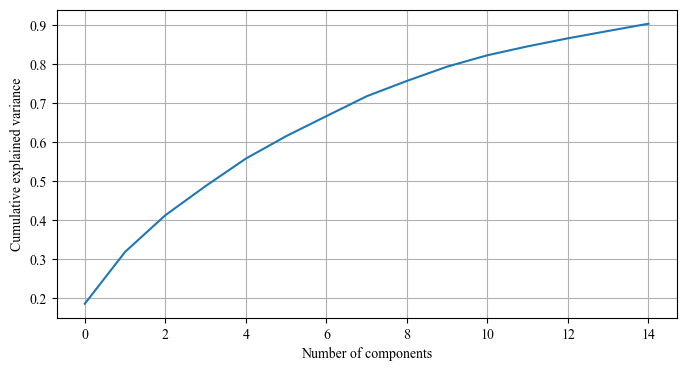

In [13]:
# plot the cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid()
#plt.show()
#plt.savefig('weights_fig/spatial_weights_pca_cev.svg', format='svg', dpi=1200, bbox_inches='tight')

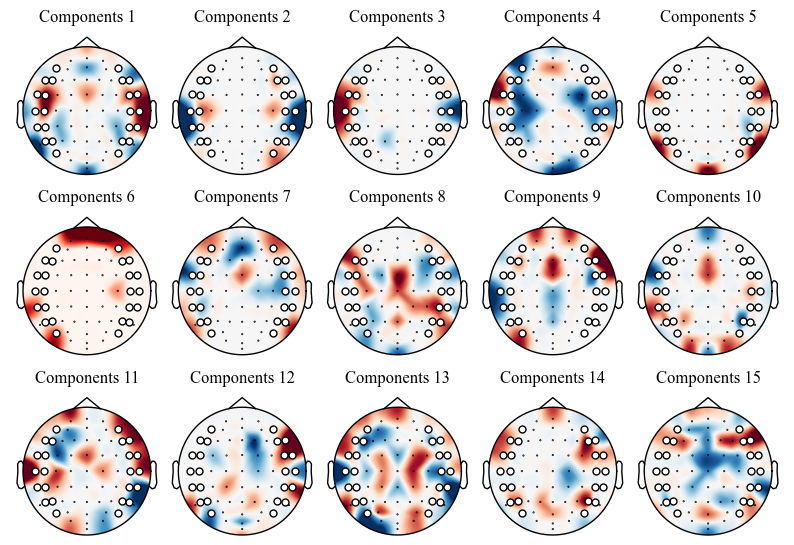

In [14]:
fig, ax = plt.subplots(3, 5, figsize=(10, 7))
fig.subplots_adjust(wspace=0.01, hspace=0.01)

for i in range(3):
    for j in range(5):
        mne.viz.plot_topomap(filter(pca.components_[i*5+j],0.4), info, 
                             axes=ax[i, j], show=False,
                             image_interp='cubic',
                             contours=0,
                             mask=mask,
                             mask_params=dict(marker='o', markerfacecolor='white', markersize=5, markeredgecolor='k'),
                             outlines='head')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title('Components %d' % (i*5+j+1), fontsize=12)


In [15]:
weights_per_component = []
# Inverse transform to get spatial weights for each component
for i in range(weights_spat_pca.shape[1]):
    weights_spat_pca_per_component = np.zeros((weights_spat_pca.shape[0], weights_spat_pca.shape[1]))
    weights_spat_pca_per_component[:,i] = weights_spat_pca[:,i]
    temp_weights_per_component = pca.inverse_transform(weights_spat_pca_per_component)
    temp_weights_per_component = temp_weights_per_component.T.reshape((weights_spat.shape[0], weights_spat.shape[1], weights_spat.shape[2]))
    weights_per_component.append(temp_weights_per_component)

weights_per_component[0].shape

(64, 8, 4)

In [ ]:
# # Plot with different components
# # Component id
# for ci in range(weights_spat_pca.shape[1]):
#     fig, ax = plt.subplots(4, 8, figsize=(20, 10))
#     fig.subplots_adjust(wspace=0.01, hspace=0.1)

#     for i in range(4):
#         for j in range(8):
#             mne.viz.plot_topomap(filter(weights_per_component[ci][:, j, i],0.3), info, 
#                                  axes=ax[i, j], show=False,
#                                  image_interp='cubic',
#                                  contours=0,
#                                  mask=mask,
#                                  mask_params=dict(marker='o', markerfacecolor='white', markersize=5, markeredgecolor='k'),
#                                  outlines='head')
#             high_mask = np.abs(weights_per_component[ci][:, j, i])>0.8
#             mne.viz.plot_topomap(filter(weights_per_component[ci][:, j, i],0.3), info, 
#                                  axes=ax[i, j], show=False,
#                                  image_interp='cubic',
#                                  contours=0,
#                                  mask=high_mask,
#                                  mask_params=dict(marker='o', markerfacecolor='green', markersize=5, markeredgecolor='k'),
#                                  outlines='head')
#             ax[i, j].set_xticks([])
#             ax[i, j].set_yticks([])
#     #plt.savefig(f'weights_fig/adt_spatial_weights_pca_{ci}.png', dpi=500, bbox_inches='tight')

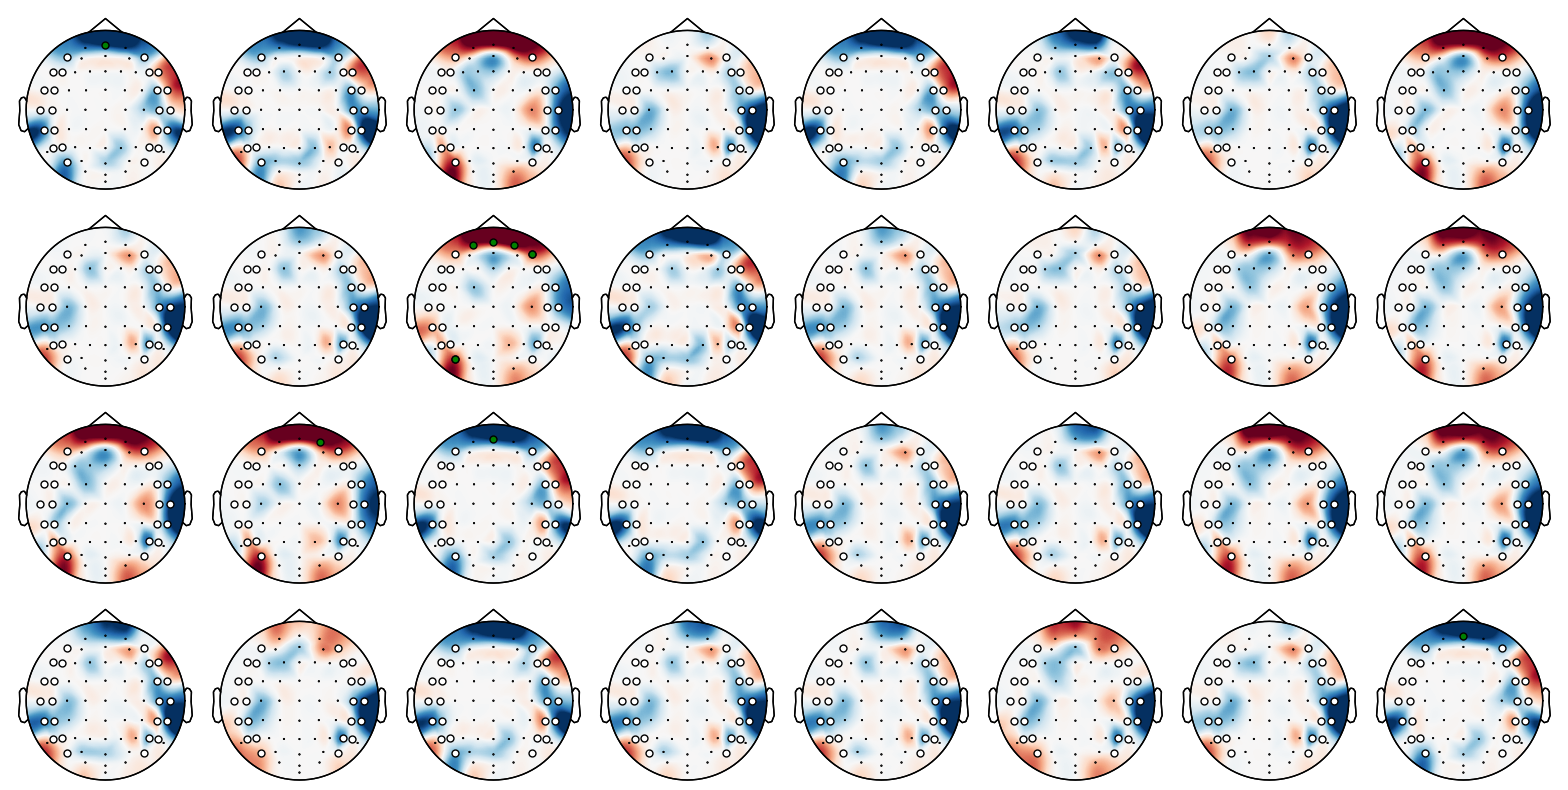

In [16]:
# Plot with different components
# Component id
ci = 5

fig, ax = plt.subplots(4, 8, figsize=(20, 10))
fig.subplots_adjust(wspace=0.01, hspace=0.1)

for i in range(4):
    for j in range(8):
        mne.viz.plot_topomap(filter(weights_per_component[ci][:, j, i],0.3), info, 
                             axes=ax[i, j], show=False,
                             image_interp='cubic',
                             contours=0,
                             mask=mask,
                             mask_params=dict(marker='o', markerfacecolor='white', markersize=5, markeredgecolor='k'),
                             outlines='head')
        high_mask = np.abs(weights_per_component[ci][:, j, i])>0.8
        mne.viz.plot_topomap(filter(weights_per_component[ci][:, j, i],0.3), info, 
                             axes=ax[i, j], show=False,
                             image_interp='cubic',
                             contours=0,
                             mask=high_mask,
                             mask_params=dict(marker='o', markerfacecolor='green', markersize=5, markeredgecolor='k'),
                             outlines='head')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])



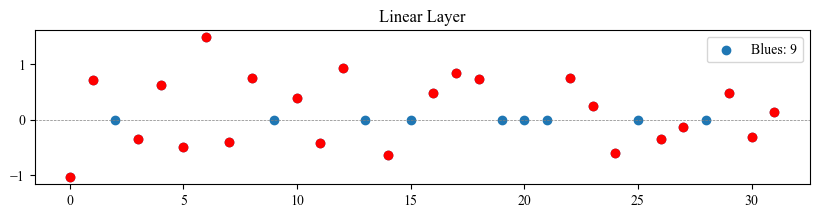

In [17]:
linear = weights[-1]
linear = np.squeeze(linear)
fig, ax = plt.subplots(1, 1, figsize=(10,2))
cax = ax.scatter(np.arange(32), linear)
num = 0
for i in range(32):
    if abs(linear[i]) > 0.05:
        ax.scatter(i, linear[i], color='red')
        num += 1
ax.axhline(0, linestyle='--', color='grey', linewidth=0.5)
ax.set_title('Linear Layer')
ax.legend([f'Blues: {32-num}'])
#plt.savefig('adt_linear_layer_32.svg', format='svg', dpi=1200, bbox_inches='tight')